# Introduction

The Cellular automata is a simple model usually calculated on a cartesian grid. With a set of simple rules and initial conditions it is possible to achieve fractals or as in this case; Conway's game of life we may simulate population growth and spread of the species. One cell represents one organism which may be alive or dead. When it's alive the cell value is set to one, when it's dead, the cell is set to zero. The rules of the game are as follow:\
1. Any live cell with less than two live neighbors or more than three live neighbors dies (underpopulation and overpopulation respectively)
2. Any live cell with two or three live neighbors lives
3. Any dead cell with exactly three live neighbors becomes alive (reproduction)\

# Methods
The simplest way of translating it to code would be a set of nested if else statements. However it is not the most efficient method and coding it, is prone to errors. To avoid nesting the rule set is encoded in 2D array where 0th row is the ruleset for dead center cell, whereas the 1st row is for the living cell.
The sum of neighbors in 2D case may take 9 values ranging from 0 to 8. Therfore the array will be of the following form\
$$\begin{bmatrix} 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 1 & 0 & 0 & 0 & 0 & 0 \\ \end{bmatrix}$$

If the cell is alive (1) and the sum of its neighbors equal 3, then these numbers are used as indices in the array above to access and assign state to the center cell.\
\
To optimize the code even more, I use convolution with a kernel which sums all the neighoboring cells (the center is set to zero to avoid counting itself).
$$\begin{bmatrix} 1 & 1 & 1 \\ 1 & 0 & 1 \\ 1 & 1 & 1 \end{bmatrix}$$

# Objectives
1. Optimize the code to run on GPU - cellular automata classes were written for CPU and GPU, and are imported from files CA_numpy (which runs on CPU) and CA_torch (which runs on GPU)
2. Cellular automata (CA) is similar to Lattice Boltzmann method (LBM) to simulate fluids. Implementation of CA is a good exercise before delving into LBM.

In [142]:
import torch
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import time
import pandas as pd
from collections import defaultdict
%run CA_torch.ipynb
%run CA_numpy.ipynb

In [143]:
def initialize_conway(N):
    '''Initializes a pattern for The Game of Life'''
    center = int(N/2)
    boundary = torch.zeros(N)
    state_initial = torch.zeros((N,N))
    # state_initial = np.eye(N, dtype='i')
    state_initial[center,center] = 1
    state_initial[center-1,center] = 1
    state_initial[center+1,center] = 1
    state_initial[center, center -1] = 1
    state_initial[center+1, center+1] = 1
    return state_initial

In [144]:
def initialize_random(N):
    '''Initialized random pattern. Used for speed comparison CPU vs GPU'''
    boundary = torch.zeros(N, dtype = float)
    state_initial = torch.randint(0,2, (N,N), dtype=torch.float32)
    state_initial[0,:] = boundary
    state_initial[N-1,:] = boundary
    state_initial[:,0] = boundary
    state_initial[:,N-1] = boundary
    return state_initial

In [145]:
if torch.cuda.is_available():
    device = torch.device("cuda")

# Conway's game of life
The state is initialized the same way as\
https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life \
since it creates interesting patterns and is used for comparison of my implementation.

In [146]:
n_cells = 50
initial_gof_torch = initialize_conway(n_cells).to(device).unsqueeze(0).unsqueeze(0).to(device)

In [147]:
initial_gof = initial_gof_torch.squeeze().detach().cpu().numpy()

In [148]:
initial_gof = initial_gof

In [149]:
gof_np = CA_numpy(initial_gof) # runs on CPU

In [150]:
gof_torch = CA_torch2(initial_gof_torch) # runs on GPU

In [151]:
def animate_numpy(time_step):
    ax.clear()
    ax.set_axis_off()
    state = gof_np.run()
    img = ax.matshow(state, cmap='Greys')
    return [img]

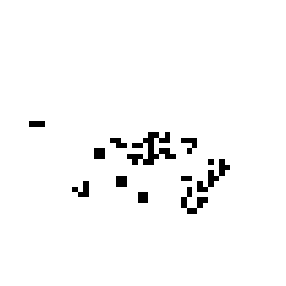

In [152]:
fig = plt.figure(figsize = (5,5))
ax = plt.axes()
ax.set_axis_off()

writer = animation.FFMpegWriter(fps = 30)
ani = animation.FuncAnimation(fig, animate_numpy, frames=100, interval = 1000, blit = True)
ani.save('GOF_CPU.mp4', writer=writer, dpi = 200)

In [153]:
def animate_torch(time_step):
    '''Separate function for animiation since for plotting the data shape has to changed to 2D
    and transferred from GPU to CPU'''
    ax.clear()
    ax.set_axis_off()
    state = gof_torch.run().squeeze()
    np_arr = state.to('cpu').numpy()
    img = ax.matshow(np_arr, cmap='Greys')
    return [img]

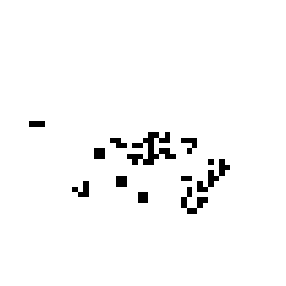

In [154]:
fig = plt.figure(figsize = (5,5))
ax = plt.axes()
ax.set_axis_off()

writer = animation.FFMpegWriter(fps = 30)
ani = animation.FuncAnimation(fig, animate_torch, frames=100, interval = 1000, blit = True)
ani.save('GOF_GPU.mp4', writer=writer, dpi = 200)

# Speed tests
The pytorch convolution works only with float type. The neighbor sum which is used as an index to lookup a value in rule set tensor needs to be converted to int. Therefore to make this test fair, the same approach was used for the numpy/scipy implementation. 1000 time steps are calculated for varius grid size.

In [34]:
grid_sizes = [100, 500, 1000, 1500] # Number of rows = Number of collumns, the problem size is for example 100x1000
results = {'size':[], 'time':[], 'unit':[]}

In [35]:
for size in grid_sizes:   
    initial_random_torch = initialize_random(size).unsqueeze(0).unsqueeze(0).to(device)
    random_torch = CA_torch2(initial_random_torch)
    
    initial_random_numpy = initial_random_torch.squeeze().detach().cpu().numpy()
    random_numpy = CA_numpy(initial_random_numpy)
    
    results['unit'].append('CPU')
    results['size'].append(size)
    start = time.time()
    for step in range(1000):
        random_numpy.run()
    end = time.time()
    
    results['time'].append(end-start)
    
    results['unit'].append('GPU')
    results['size'].append(size)
    start = time.time()
    for step in range(1000):
        random_torch.run()
    end = time.time()
    
    results['time'].append(end-start)
    

In [37]:
df = pd.DataFrame(results)

In [109]:
df

,size,time,unit
0,100,0.377000,CPU
1,100,0.136999,GPU
2,500,9.817812,CPU
3,500,0.208476,GPU
4,1000,40.750034,CPU
5,1000,1.177582,GPU
6,1500,91.271032,CPU
7,1500,1.388890,GPU


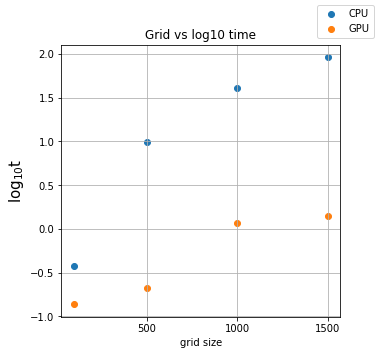

In [80]:
fig, ax = plt.subplots(figsize = (5,5))
major_ticks = np.arange(0,2000, 500)
ax.set_xticks(major_ticks, minor = False)
ax.scatter(df.loc[df['unit']=='CPU']['size'], np.log10(df.loc[df['unit']=='CPU']['time']), label = 'CPU')
ax.scatter(df.loc[df['unit']=='GPU']['size'], np.log10(df.loc[df['unit']=='GPU']['time']), label = 'GPU')
ax.set_xlabel('grid size')
ax.set_ylabel('log$_{10}$t', fontsize = 15)
plt.title('Grid vs log10 time')
fig.legend()
plt.grid()

In [130]:
speed_up = defaultdict(list)
for index in range(0, len(df.index)-1, 2):
    ratio = df.iloc[index]['time']/df.iloc[index+1]['time']
    speed_up[grid_sizes[int(index/2)]].append(ratio)
df_speed = pd.DataFrame(speed_up)
df_speed

,100,500,1000,1500
0,2.75184,47.093288,34.604844,65.7151


The speed up is tremendous, the bigger the problem the faster the GPU is, as expected. Let's see what happens if I'll keep increasing the the grid size.

In [135]:
grids = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
results_gpu = {'size':[], 'time':[]}
for size in grids:   
    initial_random_torch = initialize_random(size).unsqueeze(0).unsqueeze(0).to(device)
    random_torch = CA_torch2(initial_random_torch)
    
    results_gpu['size'].append(size)
    start = time.time()
    for step in range(1000):
        random_torch.run()
    end = time.time()
    
    results_gpu['time'].append(end-start)

In [137]:
df_gpu = pd.DataFrame(results_gpu)
df_gpu

,size,time
0,100,0.140001
1,500,0.132035
2,1000,0.170782
3,1500,0.357156
4,2000,0.612143
5,2500,0.975312
6,3000,1.422947
7,3500,1.927924
8,4000,2.439372
9,4500,3.124909


## Scaling the grid 100 times, the GPU is still twice faster than CPU.